## Einlesen und Verarbeiten eines RAW-Bilder
### Am Beispiel der Raspberry Pi camera
Das eingelesene Bild enthält neben dem JPEG noch einen Bereich mit den Rohdaten (Sensorinformationen, die selbst ausgelesen und weiterverabeitet werden können)
- Bild einelesen
- Daten extrahieren
- 10bit aus 5 Byte konvertieren in 4 Farbinformationen (Pixel)
- 

(2464, 3280, 3)

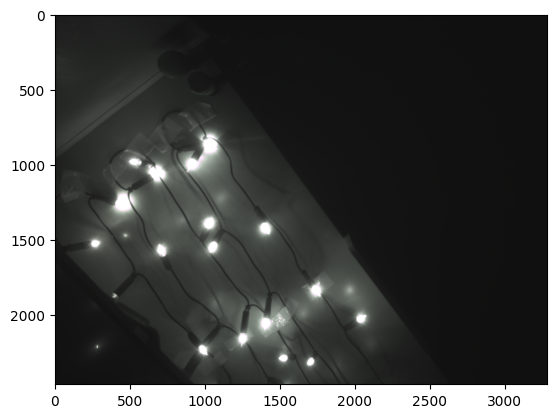

In [6]:
import io
# import time
import numpy as np
import matplotlib.pyplot as plt
# import cv2
from numpy.lib.stride_tricks import as_strided

# Read file from disk as Byte stream
stream = io.BytesIO(np.fromfile("image.jpg", dtype='uint8'))

# Extract the raw Bayer data from the end of the stream, check the
# header and strip if off before converting the data into a numpy array

offset = 10270208 # valid for pi camera V2
data = stream.getvalue()[-offset:]
data = data[32768:] # strip off the 32kb header
data = np.frombuffer(data, dtype=np.uint8)

# For the V2 module, the data consists of 2480 rows of 4128 bytes of data.
# There's actually 2464 rows of data, but the sensor's raw size is 2466
# rows, rounded up to the nearest multiple of 16: 2480.
#
# Likewise, the last few bytes of each row are unused (why?). Here we
# reshape the data and strip off the unused bytes.

reshape, crop = ((2480, 4128), (2464, 4100))
data = data.reshape(reshape)[:crop[0], :crop[1]]

# Horizontally, each row consists of 10-bit values. Every four bytes are
# the high 8-bits of four values, and the 5th byte contains the packed low
# 2-bits of the preceding four values. In other words, the bits of the
# values A, B, C, D and arranged like so:
#
#  byte 1   byte 2   byte 3   byte 4   byte 5
# AAAAAAAA BBBBBBBB CCCCCCCC DDDDDDDD AABBCCDD
#
# Here, we convert our data into a 16-bit array, shift all values left by
# 2-bits and unpack the low-order bits from every 5th byte in each row,
# then remove the columns containing the packed bits

data = data.astype(np.uint16) << 2
for byte in range(4):
    data[:, byte::5] |= ((data[:, 4::5] >> ((4 - byte) * 2)) & 0b11)
data = np.delete(data, np.s_[4::5], 1)

# Now to split the data up into its red, green, and blue components. The
# Bayer pattern of the OV5647 sensor is BGGR. In other words the first
# row contains alternating green/blue elements, the second row contains
# alternating red/green elements, and so on as illustrated below:
#
# GBGBGBGBGBGBGB
# RGRGRGRGRGRGRG
# GBGBGBGBGBGBGB
# RGRGRGRGRGRGRG
#
# Please note that if you use vflip or hflip to change the orientation
# of the capture, you must flip the Bayer pattern accordingly

rgb = np.zeros(data.shape + (3,), dtype=data.dtype)
rgb[1::2, 0::2, 0] = data[1::2, 0::2] # Red
rgb[0::2, 0::2, 1] = data[0::2, 0::2] # Green
rgb[1::2, 1::2, 1] = data[1::2, 1::2] # Green
rgb[0::2, 1::2, 2] = data[0::2, 1::2] # Blue

# At this point we now have the raw Bayer data with the correct values
# and colors but the data still requires de-mosaicing and
# post-processing. If you wish to do this yourself, end the script here!
#
# Below we present a fairly naive de-mosaic method that simply
# calculates the weighted average of a pixel based on the pixels
# surrounding it. The weighting is provided by a byte representation of
# the Bayer filter which we construct first:

bayer = np.zeros(rgb.shape, dtype=np.uint8)
bayer[1::2, 0::2, 0] = 1 # Red
bayer[0::2, 0::2, 1] = 1 # Green
bayer[1::2, 1::2, 1] = 1 # Green
bayer[0::2, 1::2, 2] = 1 # Blue

# Allocate an array to hold our output with the same shape as the input
# data. After this we define the size of window that will be used to
# calculate each weighted average (3x3). Then we pad out the rgb and
# bayer arrays, adding blank pixels at their edges to compensate for the
# size of the window when calculating averages for edge pixels.

output = np.empty(rgb.shape, dtype=rgb.dtype)
window = (3, 3)
borders = (window[0] - 1, window[1] - 1)
border = (borders[0] // 2, borders[1] // 2)

rgb = np.pad(rgb, [
    (border[0], border[0]),
    (border[1], border[1]),
    (0, 0),
    ], 'constant')
bayer = np.pad(bayer, [
    (border[0], border[0]),
    (border[1], border[1]),
    (0, 0),
    ], 'constant')

# For each plane in the RGB data, we use a nifty numpy trick
# (as_strided) to construct a view over the plane of 3x3 matrices. We do
# the same for the bayer array, then use Einstein summation on each
# (np.sum is simpler, but copies the data so it's slower), and divide
# the results to get our weighted average:

for plane in range(3):
    p = rgb[..., plane]
    b = bayer[..., plane]
    pview = as_strided(p, shape=(
        p.shape[0] - borders[0],
        p.shape[1] - borders[1]) + window, strides=p.strides * 2)
    bview = as_strided(b, shape=(
        b.shape[0] - borders[0],
        b.shape[1] - borders[1]) + window, strides=b.strides * 2)
    psum = np.einsum('ijkl->ij', pview)
    bsum = np.einsum('ijkl->ij', bview)
    output[..., plane] = psum // bsum

# At this point output should contain a reasonably "normal" looking
# image, although it still won't look as good as the camera's normal
# output (as it lacks vignette compensation, AWB, etc).
#
# If you want to view this in most packages (like GIMP) you'll need to
# convert it to 8-bit RGB data. The simplest way to do this is by
# right-shifting everything by 2-bits (yes, this makes all that
# unpacking work at the start rather redundant...)
display(output.shape)

output = (output >> 2).astype(np.uint8)[:,:,:]
# Pyplot mit Bild verbinden
plt.imshow(output)
# Bild anzeigen
plt.show()
with open('image.data', 'wb') as f:
    output.tofile(f)